In [1]:
%matplotlib inline
import time
import numpy as np
from numpy import sqrt, cos, sin, pi
from numpy.fft import fft, ifft, rfft, irfft
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### Generate data

In [3]:
nsamples_train = 10000
nsamples_test = 100
nsamples = nsamples_train + nsamples_test

In [4]:
# physics parameters that define the input (feature) and output (label)
n0 = 1.
vt = 1.
chi1 = 2. / sqrt(pi)

lx = 2. * pi
nx = 128
kmax = 8

In [5]:
def make_modes(x, kmax, magnitude=1.):
    """Make many sinusoidal modes with random amplitudes and phases.

    Args:
        x: 1d spatial coordinates.
        kmax: k = 1, 2, ..., kmax.

    Returns:
        modes: Superposition of all modes.
    """
    A = np.random.random((kmax)) * magnitude
    phi = np.random.random((kmax)) * pi * 2
    modes = np.zeros_like(x)
    for k in range(1, kmax):
        A_k = A[k]
        phi_k = phi[k]
        modes += A_k * np.cos(k * x + phi_k)
    return modes


def make_training_data():
    x = np.linspace(0, lx, nx)
    k = np.fft.fftfreq(nx, d=lx/nx) * 2. * pi

    T_all = []
    q_all = []

    coeff_q = -n0 * chi1 * sqrt(2) * vt * 1j * np.sign(k)

    for isample in tqdm(range(nsamples)):
        # Temperature flucutations in real space, T(x)
        T = make_modes(x, kmax)
        # Temperature fluctuations in Fourier spacer, T(k)
        Tk = fft(T)
        # heatflux fluctuation in Fourier space, q(k)
        qk = coeff_q * Tk
        # heatflux fluctuation in real space, q(x)
        q = ifft(qk).real

        # append real-space input/output of this sample
        T_all.append(T)
        q_all.append(q)

    # convert to ndarray of shape (nsamples, nx)
    T_all = np.array(T_all, dtype='f4')
    q_all = np.array(q_all, dtype='f4')

    return T_all, q_all


def normalize(arr):
    # all data have mean=0
    # XXX use the same max
    return arr / abs(arr).max()

In [6]:
T, q = make_training_data()

100%|██████████| 10100/10100 [00:01<00:00, 9074.15it/s]


In [7]:
T = normalize(T)
q = normalize(q)

In [8]:
# using data loader?
train_inputs = torch.tensor(T[:nsamples_train, ...])
train_labels = torch.tensor(q[:nsamples_train, ...])

test_inputs = torch.tensor(T[nsamples_train:, ...])
test_labels = torch.tensor(q[nsamples_train:, ...])

### Create the model

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(128, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 128)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # FIXME linear?
        return x


net = Net()
print(net)

Net(
  (fc1): Linear(in_features=128, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
)


In [10]:
criterion = nn.L1Loss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

### Train the model

In [13]:
nepochs = 100
batch_size = 25
nbatches = train_inputs.shape[0] // batch_size

for epoch in range(nepochs):

    running_loss = 0.0
    for i in range(nbatches):
        inputs = train_inputs[i*batch_size:(i+1)*batch_size, ...]
        labels = train_labels[i*batch_size:(i+1)*batch_size, ...]
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % nbatches == 0:
            print('[%d, %5d] loss: %g' %
                  (epoch, i, running_loss / nbatches))
            running_loss = 0.0

print('Finished Training')

[0,     0] loss: 9.58969e-06
[1,     0] loss: 1.00488e-05
[2,     0] loss: 1.08726e-05
[3,     0] loss: 9.12489e-06
[4,     0] loss: 1.0125e-05
[5,     0] loss: 1.07594e-05
[6,     0] loss: 1.1278e-05
[7,     0] loss: 9.19167e-06
[8,     0] loss: 9.58581e-06
[9,     0] loss: 1.03665e-05
[10,     0] loss: 9.43328e-06
[11,     0] loss: 9.37743e-06
[12,     0] loss: 9.73665e-06
[13,     0] loss: 9.80819e-06
[14,     0] loss: 9.27033e-06
[15,     0] loss: 9.12873e-06
[16,     0] loss: 1.03351e-05
[17,     0] loss: 9.00218e-06
[18,     0] loss: 1.01652e-05
[19,     0] loss: 9.29228e-06
[20,     0] loss: 1.03338e-05
[21,     0] loss: 9.86501e-06
[22,     0] loss: 9.82569e-06
[23,     0] loss: 8.95234e-06
[24,     0] loss: 9.38e-06
[25,     0] loss: 8.9979e-06
[26,     0] loss: 9.29497e-06
[27,     0] loss: 9.84057e-06
[28,     0] loss: 9.88921e-06
[29,     0] loss: 9.0964e-06
[30,     0] loss: 9.9069e-06
[31,     0] loss: 9.75786e-06
[32,     0] loss: 8.36573e-06
[33,     0] loss: 8.89268e-0

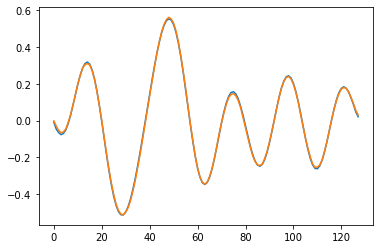

In [14]:
with torch.no_grad():  # test only, do not nudge the model
    test_labels_pred = net(test_inputs)
    for i in range(1):
        plt.plot(test_labels[0, ...])
        plt.plot(test_labels_pred[0, ...])